In [1]:
username = "Alex"
pathtorepo = "C:\\Users\\" *username *  "\\Desktop\\"
using Pkg
Pkg.activate(pathtorepo * "dynamical-systems\\env\\integrate\\")
include(pathtorepo * "dynamical-systems\\system.jl")

  Activating project at `C:\Users\Alex\Desktop\dynamical-systems\env\integrate`

HR_mem (generic function with 1 method)

In [2]:
using StaticArrays, DifferentialEquations, DynamicalSystems, JLD
E, x, y  = -40..40, -5..5,  -5..5
box = E × x × y
using CairoMakie, GLMakie
using LinearAlgebra

In [3]:
const τ = 0.013;  const τD = 0.07993;  const τy = 3.3;  const J = 3.07;  const β = 0.300
const xthr = 0.75; const ythr = 0.4; const α = 1.58; const ΔU0 = 0.305;

In [14]:
t = 1000; tt = 500; tstep = 0.001; tspan = [time, tt]
integ_set = (alg = Vern9(), adaptive = false, dt = tstep);

In [68]:
I0 = -1.707; U0 = 0.26504556977786675
p = SA[α, τ, τD, τy, J, xthr, ythr, U0, ΔU0, β, I0]
u0 = [11.325905642223786, 0.6594706953104683, 0.4863175026548461];

In [69]:
ds = CoupledODEs(TM, u0, p, diffeq = integ_set)

3-dimensional CoupledODEs
 deterministic: true
 discrete time: false
 in-place:      false
 dynamic rule:  TM
 ODE solver:    Vern9
 ODE kwargs:    (adaptive = false, dt = 0.001)
 parameters:    [1.58, 0.013, 0.07993, 3.3, 3.07, 0.75, 0.4, 0.26504556977786675, 0.305, 0.3, -1.707]
 time:          0.0
 state:         [11.325905642223786, 0.6594706953104683, 0.4863175026548461]


In [70]:
fp, ei, _ = fixedpoints(ds, box, jacob_TM_)

index_fp = 1
index_vec = 1
ϵ = 1e-9

Jac = jacob_TM_(fp[index_fp], p, 0)
eivecs = eigvecs(Jac)
shift =  fp[index_fp] + real(eivecs[:, index_vec])*ϵ
println("fixed point with shift along stable manifold: $(shift)")

fixed point with shift along stable manifold: [8.345113139326603, 0.7384945442311112, 0.4382979723388005]


In [71]:
sol, trange = trajectory(ds, t, Ttr = tt, Δt = integ_set.dt)
println("Length sol: $(length(sol))");

Length sol: 1000001


In [72]:
lb_size_ts = 30; tck_size_ts = 25
width = 2000; height = 600;

In [73]:
function global_max(timesereis, ϵ = 1e-2)
    tr, trange = timeseries
    glob_maxs, trange_glob_maxs = Float64[], Float64[]
    real_global_max =floor(maximum(tr), digits = 3)
    idxs = Int64[]
    for idx in range(2, length(tr) - 1, step = 1)
        if tr[idx-1] < tr[idx] > tr[idx+1]
            if abs(tr[idx] -real_global_max) <= ϵ
                push!(glob_maxs, tr[idx])
                push!(trange_glob_maxs, trange[idx])
                push!(idxs, idx)
            end
        end
    end
    return glob_maxs,trange_glob_maxs, idxs
end
function local_max(timeseries)
    tr, trange = timeseries
    localmaxs, trange_local_maxs = Float64[], Float64[]
    idxs = Int64[]
    for idx in range(2, length(tr) - 1, step = 1)
        if tr[idx-1] < tr[idx] > tr[idx+1]
            push!(localmaxs, tr[idx])
            push!(trange_local_maxs, trange[idx])
            push!(idxs, idx)
        end
    end
    
    return localmaxs, trange_local_maxs, idxs
end

local_max (generic function with 1 method)

In [74]:
timeseries = [sol[:, 3], trange]
glob_maxs , trange_glob_maxs, idxs = global_max(timeseries, 9e-2)

([0.5866071612048731, 0.5892364868738714, 0.5905970148445112, 0.5895816792178966, 0.5875371700508423, 0.5868200876101463, 0.5902005972362429, 0.5264720724364302, 0.5883855291221111, 0.5865140613825908  …  0.5867634867018361, 0.5875837593852566, 0.5867211613205919, 0.5906644819137257, 0.5893282628470244, 0.5878258463710289, 0.5864002169938847, 0.5865829593172386, 0.5885725768537948, 0.586819106567723], [501.637, 507.206, 512.353, 517.004, 584.477, 589.542, 616.596, 620.746, 623.853, 628.924  …  1421.553, 1434.594, 1439.658, 1449.253, 1453.901, 1460.523, 1465.585, 1471.109, 1476.668, 1481.745], [1638, 7207, 12354, 17005, 84478, 89543, 116597, 120747, 123854, 128925  …  921554, 934595, 939659, 949254, 953902, 960524, 965586, 971110, 976669, 981746])

In [118]:
idst, ided = 86, 87

localtimeseries = [ sol[idxs[idst]:idxs[ided], 3], trange[idxs[idst]:idxs[ided]] ]
localmaxs, trange_locamaxs, idxss = local_max(localtimeseries)

localtimeseriesE = [ sol[idxs[idst]:idxs[ided], 1], trange[idxs[idst]:idxs[ided]] ]
localmaxsE, trange_locamaxE, idxsEs = local_max(localtimeseriesE)
length(localmaxsE) - length(localmaxs)

7

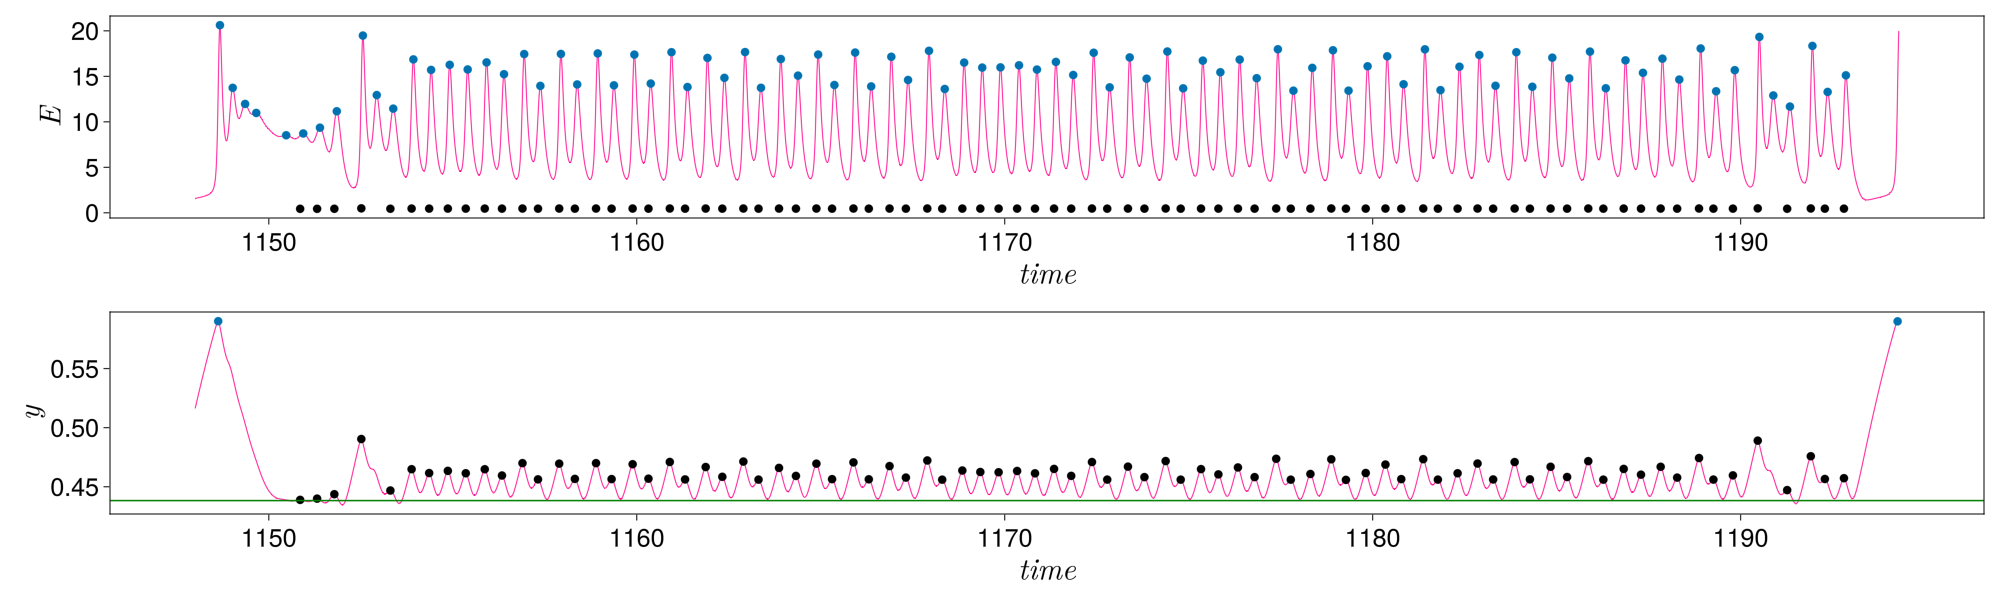

In [135]:
ts, tf = 648000, 694300
tsgl, tfgl = idst, ided

f = Figure(resolution = (width, height))
axisE = Axis(f[1, 1], xlabel = L"$time$", ylabel = L"$E$",
            xlabelsize = lb_size_ts, ylabelsize = lb_size_ts,
            xticklabelsize = tck_size_ts, yticklabelsize = tck_size_ts,
            xgridvisible = false, ygridvisible = false)

axisy = Axis(f[2, 1], xlabel = L"$time$", ylabel = L"$y$",
            xlabelsize = lb_size_ts, ylabelsize = lb_size_ts,
            xticklabelsize = tck_size_ts, yticklabelsize = tck_size_ts,
            xgridvisible = false, ygridvisible = false)

lines!(axisE, trange[ts:tf], sol[ts:tf, 1], linewidth = 1.0, color = :deeppink)
scatter!(axisE, trange_locamaxs, localmaxs, color = :black)
scatter!(axisE, trange_locamaxE, localmaxsE)



lines!(axisy, trange[ts:tf], sol[ts:tf, 3], linewidth = 1.0, color = :deeppink)
scatter!(axisy, trange_glob_maxs[tsgl:tfgl], glob_maxs[tsgl:tfgl])
scatter!(axisy, trange_locamaxs, localmaxs, color = :black)

hlines!(axisy, fp[1][3], color = :green)
#ylims!(axisy, 0.425, 0.5)
f

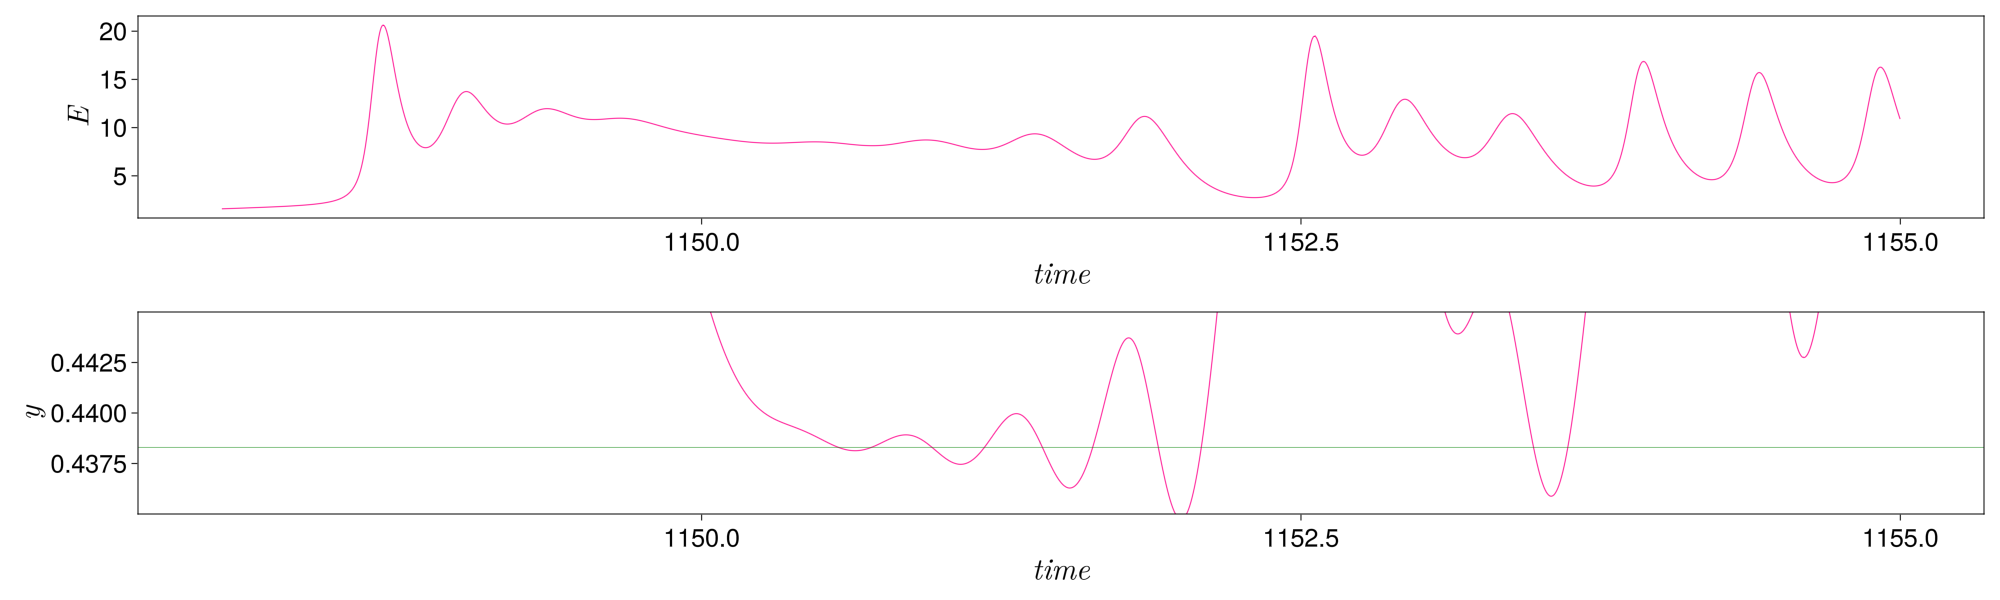

In [149]:
ts, tf = 648000, 655000
tsgl, tfgl = idst, ided

f = Figure(resolution = (width, height))
axisE = Axis(f[1, 1], xlabel = L"$time$", ylabel = L"$E$",
            xlabelsize = lb_size_ts, ylabelsize = lb_size_ts,
            xticklabelsize = tck_size_ts, yticklabelsize = tck_size_ts,
            xgridvisible = false, ygridvisible = false)

axisy = Axis(f[2, 1], xlabel = L"$time$", ylabel = L"$y$",
            xlabelsize = lb_size_ts, ylabelsize = lb_size_ts,
            xticklabelsize = tck_size_ts, yticklabelsize = tck_size_ts,
            xgridvisible = false, ygridvisible = false)

lines!(axisE, trange[ts:tf], sol[ts:tf, 1], linewidth = 1.0, color = :deeppink)


lines!(axisy, trange[ts:tf], sol[ts:tf, 3], linewidth = 1.0, color = :deeppink)

hlines!(axisy, fp[1][3], color = :green, linewidth = 0.5)
ylims!(axisy, 0.435, 0.445)
f

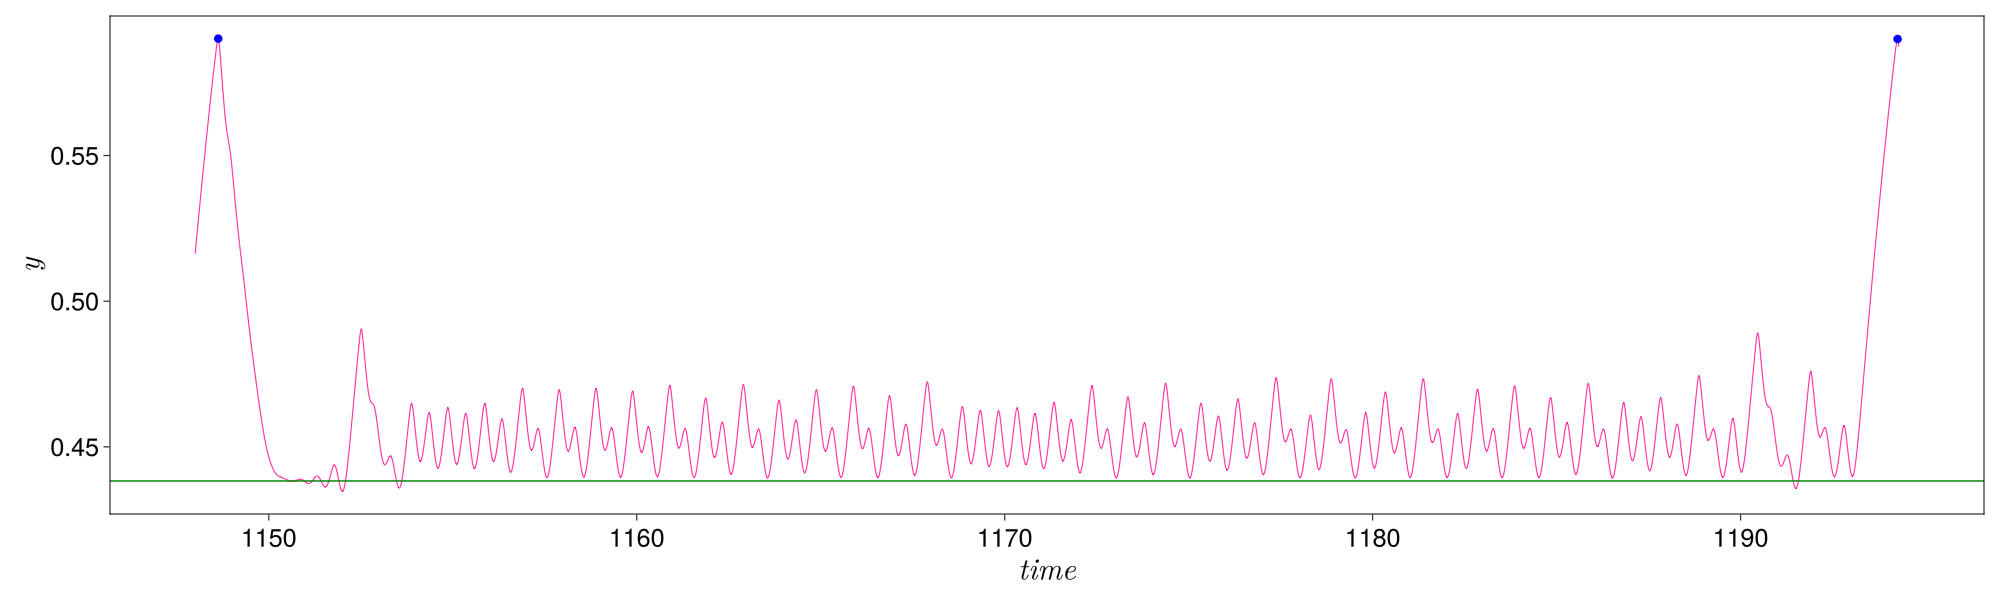

In [134]:
ts, tf = 648000, 694300
tsgl, tfgl = 86, 87

f = Figure(resolution = (width, height))
axisy = Axis(f[1, 1], xlabel = L"$time$", ylabel = L"$y$",
            xlabelsize = lb_size_ts, ylabelsize = lb_size_ts,
            xticklabelsize = tck_size_ts, yticklabelsize = tck_size_ts,
            xgridvisible = false, ygridvisible = false)


lines!(axisy, trange[ts:tf], sol[ts:tf, 3], linewidth = 1.0, color = :deeppink)
scatter!(axisy, trange_glob_maxs[tsgl:tfgl], glob_maxs[tsgl:tfgl], color = :blue)

hlines!(axisy, fp[1][3], color = :green)
#ylims!(axisy, 0.425, 0.5)
f

In [440]:
tsgl, tfgl = idst, ided

idx, idy, idz = 2, 3, 1
dis  = 60;

f = Figure(resolution = (700, 700))
ax = LScene(f[1, 1], show_axis = true)

scale!(ax.scene, 50, 50, 1)

"""ax = Axis3(f[1, 1], azimuth = 0.4pi,
            xlabel = "E", ylabel = "y", zlabel = "x",
            xlabelsize = lb_size_ts, ylabelsize = lb_size_ts, zlabelsize = lb_size_ts,
            xticklabelsize = tck_size_ts, yticklabelsize = tck_size_ts, zticklabelsize = tck_size_ts,
            xgridvisible = false, ygridvisible = false, zgridvisible = false,
            protrusions = dis, xlabeloffset = dis, ylabeloffset = dis, zlabeloffset = dis)"""


lines!(sol[ts:tf, idx], sol[ts:tf, idy], sol[ts:tf, idz],
    linewidth = 1.0, color = :black)

for (i, ep) in enumerate(fp)
    scatter!(ep[idx], ep[idy], ep[idz], color = :blue, markersize = 12)
end

display(GLMakie.Screen(), f)

GLMakie.Screen(...)